In [1]:
import random
from numba import njit
from tqdm import tqdm, trange

import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import sklearn

import torch
from torch import nn

source = "../source"
sys.path.append(source)


from data import seq_data, gen_rand_seq
from preprocessing import OneHot
from compilation import Compiler, ScalarTracker, ActivationTracker
from data_analysis.automata import (
    to_automaton_history,
    reduce_automaton,
    to_automaton,
    gen_rand_automaton,
    gen_tree,
    Automaton,
    State,
)
from visualization.animation import SliderAnimation
from visualization.activations import ActivationsAnimation
from visualization.automata import AutomatonAnimation, display_automata
from visualization.epochs import EpochAnimation

from model import Model
import publication

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [2]:
# ## Settings parity task with relu
# settings = "parity"
# nonlinearity = "relu"
# P = 100
# L = 1

# gain = 0.1
# lr = 0.02
# n_epochs = 1000

# min_seq_len = 1
# max_seq_len = 10

# symbols = [0, 1]
# encoding = OneHot(symbols)
# automaton_problem = None
# problem = lambda seq: int(np.sum(seq) % 2)

# thresh_factor = 0.01

In [3]:
## Settings parity task with tanh
settings = "parity_tanh"
nonlinearity = "tanh"
P = 100
L = 1

gain = 0.2
lr = 0.05
n_epochs = 1000

min_seq_len = 1
max_seq_len = 10

symbols = [0, 1]
encoding = OneHot(symbols)
automaton_problem = None
problem = lambda seq: int(np.sum(seq) % 2)

thresh_factor = 0.1

In [4]:
# ## Settings random task with relu
# settings = "random"
# nonlinearity = "relu"
# P = 100
# L = 1

# gain = 0.05
# lr = 0.05
# n_epochs = 1000

# max_problem_size = 7
# min_seq_len = 1
# max_seq_len = 10

# symbols = [0, 1]
# encoding = OneHot(symbols)
# automaton_problem = gen_rand_automaton(symbols, [[1, 0], [0, 1]], max_problem_size, 0.6)
# problem = lambda seq: int(np.argmax(automaton_problem.compute(seq)))

# thresh_factor = 0.01

# gain = 0.025
# # thresh_factor = 0.1

# gain = 0.03
# thresh_factor = 0.05

In [6]:
# ## Settings repeat task with relu
# settings = "repeat"
# nonlinearity = "relu"
# P = 100
# L = 1

# # gain = 0.0000000001
# gain = 0.2
# lr = 0.05
# n_epochs = 500

# max_seq_len = 10

# symbols = [0, 1]
# encoding = OneHot(symbols)
# pattern_len = 3
# problem = lambda seq: (
#     seq[int(len(seq) % pattern_len)] if len(seq) > pattern_len - 1 else 0
# )
# min_seq_len = pattern_len

# thresh_factor = 0.01

In [7]:
## Generate data

# Define sequence lengths for training and validation datasets
train_seq_lengths = list(range(min_seq_len, max_seq_len + 1))
analysis_seq_lengths = list(range(1, max_seq_len + 1))
long_seq_lens = [25, 100, 250, 1000, 2500, 10000]
val_seq_length = 50
val_datapoints = 100

# Generate datasets
training_datasets = [
    seq_data(device, problem, encoding, seq_len=length) for length in train_seq_lengths
]
validation_datasets = [
    seq_data(
        device, problem, encoding, n_datapoints=val_datapoints, seq_len=val_seq_length
    )
]
analysis_data = [
    seq_data(device, problem, encoding, seq_len=length)
    for length in analysis_seq_lengths
]
long_seq_val_datasets = [
    seq_data(device, problem, encoding, n_datapoints=10, seq_len=length)
    for length in long_seq_lens
]
tracked_datasets = (
    validation_datasets + analysis_data + training_datasets + long_seq_val_datasets
)


if automaton_problem:
    display_automata(reduce_automaton(automaton_problem))
    publication.pub_show(save_path=f"plots/{settings}_automaton_task_reduced")

In [8]:
## Instantiate model
model = Model(
    encoding=encoding,
    input_size=len(symbols),
    output_size=len(symbols),
    hidden_dim=P,
    n_layers=L,
    device=device,
    nonlinearity=nonlinearity,
    gain=gain,
)

In [9]:
## Setup compiler
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)
compiler = Compiler(model, criterion, optimizer)
initial_hidden = model.init_hidden(batch_size=1)[-1]
hidden_function = lambda inputs: model(inputs)[1][-1]
output_function = lambda inputs: model(inputs)[0]
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        encoding,
        hidden_function,
        analysis_data,
        initial=lambda: initial_hidden,
    ),
    "output": ActivationTracker(encoding, output_function, analysis_data),
}

In [10]:
# Train
compiler.training_run(
    training_datasets,
    n_epochs=n_epochs,
    batch_size=128,
)

Training:   1%|          | 9/1000 [00:07<14:06,  1.17steps/s, train_loss=0.25110, val_loss=0.25198]

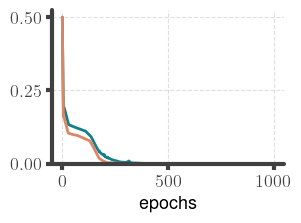

In [11]:
loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()
n_datapoints = sum(len(dataset) for dataset in training_datasets)

publication.set_color_mixed()
plt.figure(figsize=(3, 2))
plt.plot(train_loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
plt.xlabel("epochs")
plt.ylim(0)
# plt.legend()
publication.plt_show(save_path=f"plots/{settings}_loss_small")

Computing automata: 100%|██████████| 1000/1000 [04:55<00:00,  3.38it/s]


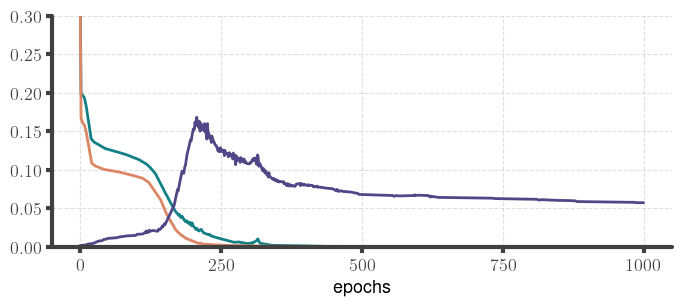

In [12]:
## Visualize automaton dynamics

# Filter and process data for visualization
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = "(Dataset <= 12)"
data_hid = data_hid.query(query).copy()
data_output = data_output.query(query).copy()

epochs = list(set(data_hid.index.get_level_values("Epoch")))
epochs.sort()

std = float(np.linalg.norm(data_hid.std()))
threshold = thresh_factor * std
n_points = len(data_hid.query("Epoch == 0"))

loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()
automaton_history = to_automaton_history(
    data_hid, data_output, merge_distance=threshold
)
n_states = np.array([len(automaton.states) for automaton in automaton_history])
is_finite = np.array([automaton.is_finite() for automaton in automaton_history])

n_datapoints = sum(len(dataset) for dataset in analysis_data)

publication.set_color_mixed()
plt.figure(figsize=(8, 3))
plt.plot(np.array(train_loss), label="Training loss")
plt.plot(val_loss, label="Validation loss")
plt.plot(n_states / n_datapoints, label="Number of states")
plt.xlabel("epochs")
plt.ylim(0, 0.3)
publication.plt_show(save_path=f"plots/{settings}_loss")

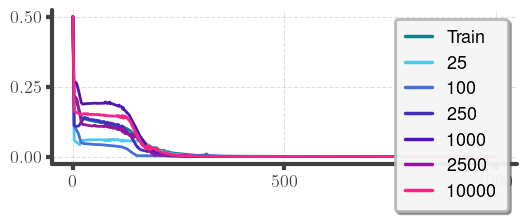

In [ ]:
long_seq_losses = [
    loss.query(f"Dataset=={len(tracked_datasets)-n-1}")[0].to_numpy()
    for n in range(len(long_seq_lens))
]
long_seq_losses = long_seq_losses[::-1]

plt.figure(figsize=(6, 2))

publication.set_color_mixed()
plt.gca().set_prop_cycle(None)
plt.plot(epochs, train_loss, label="Train")


publication.set_color_gradient(1, len(long_seq_lens))
plt.gca().set_prop_cycle(None)
for length, loss_this_len in zip(long_seq_lens, long_seq_losses):
    plt.plot(epochs, loss_this_len, label=length)


plt.legend()
publication.plt_show(save_path=f"plots/{settings}_validation")

KeyError: State(0000101111, 000101111, 0010101111, 0100101111, 1000101111, 100101111, 1010101111, 10101111, 1011101111, 1100101111, 1110101111, 11101111, 1111101111)

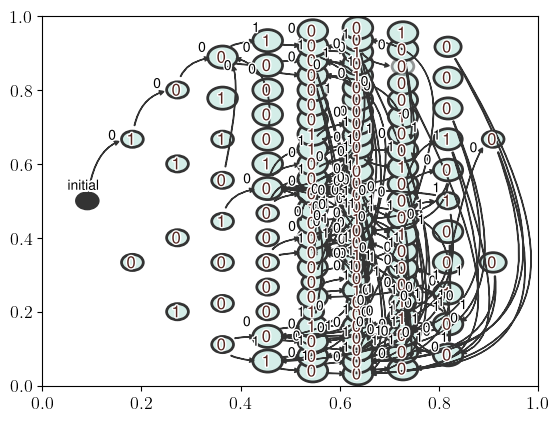

In [34]:
## Display automaton during training

epoch_choices = [0]

for epoch in epoch_choices:
    automaton = automaton_history[epoch]
    display_automata(automaton)
    # publication.pub_show(save_path=f"plots/{settings}_automaton_epoch_{epoch}")

Computing automata: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


KeyError: State(0000010110, 000010110, 0001010110, 00010110, 0001110110, 0010010110, 001010110, 0011010110, 0011110110, 0100010110, 010010110, 0101010110, 0110010110, 1000010110, 100010110, 1001010110, 10010110, 1001110110, 1010010110, 101010110, 1010110, 10110, 1011010110, 101110110, 1100010110, 110010110, 1101010110, 1101110110, 1110010110, 111010110, 1110110, 1111010110, 111110110)

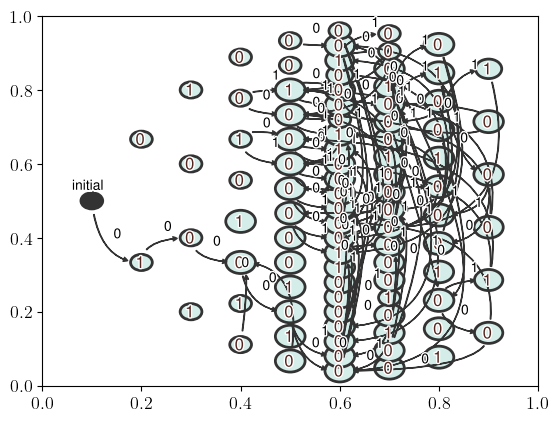

In [ ]:
## Compare task to learned automaton

learned_automaton = to_automaton(
    hidden_function,
    output_function,
    initial_hidden,
    analysis_data,
    encoding,
    merge_distance_frac=threshold,
)


display_automata(learned_automaton)
publication.pub_show(save_path=f"plots/{settings}_automaton")

display_automata(reduce_automaton(learned_automaton))
publication.pub_show(save_path=f"plots/{settings}_automaton_reduced")

if automaton_problem:
    display_automata(reduce_automaton(automaton_problem))
    publication.pub_show(save_path=f"plots/{settings}_automaton_task_reduced")

In [ ]:
## Plot number of diverging state mergers per sequence length pairs
last_epoch = int(data_hid.index.get_level_values("Epoch")[-1])
data_hid_analyze = data_hid.query("Dataset != -1")

merger_counts = np.zeros((len(training_datasets), len(training_datasets)))
diverging_merger_counts = np.zeros((len(training_datasets), len(training_datasets)))
total_mergers = 0
total_possible_mergers = 0
total_pred_mergers = 0
total_unpred_mergers = 0
total_diverging_mergers = 0
for dataset_1, hid_1_full in data_hid_analyze.groupby("Dataset"):
    print(dataset_1)
    hid_1 = hid_1_full.query(f"Epoch == {last_epoch}")
    h_1 = hid_1.to_numpy()
    labels_1 = hid_1.index.get_level_values("Input").to_numpy()
    outputs_1 = [problem(list(map(int, x))) for x in labels_1]
    for dataset_2, hid_2_full in data_hid_analyze.groupby("Dataset"):
        hid_2 = hid_2_full.query(f"Epoch == {last_epoch}")
        if dataset_1 == 0 and dataset_2 == 0:
            break
        h_2 = hid_2.to_numpy()
        H = scipy.spatial.distance_matrix(h_1, h_2)
        mergers = H < threshold

        labels_2 = hid_2.index.get_level_values("Input").to_numpy()
        outputs_2 = [problem(list(map(int, x))) for x in labels_2]

        possible_mergers = np.array(
            [[y_1 == y_2 for y_2 in outputs_2] for y_1 in outputs_1]
        )
        possible_mergers_sum = int(np.sum(possible_mergers) / 2)
        if dataset_1 == dataset_2:
            np.fill_diagonal(mergers, False)
            possible_mergers_sum -= len(hid_1) / 2
        count = int(np.sum(mergers) / 2)
        merger_counts[dataset_1, dataset_2] = count / possible_mergers_sum

        diverging_mergers = mergers
        never_splits = np.full(mergers.shape, True)
        for epoch in range(last_epoch):
            h_1_epoch = hid_1_full.query(f"Epoch == {epoch}").to_numpy()
            h_2_epoch = hid_2_full.query(f"Epoch == {epoch}").to_numpy()
            H_epoch = scipy.spatial.distance_matrix(h_1_epoch, h_2_epoch)
            mergers_epoch = H_epoch < 10 * threshold
            never_splits = never_splits * mergers_epoch
        diverging_merger_count = int(np.sum(mergers * (1 - never_splits)) / 2)
        diverging_merger_counts[dataset_1, dataset_2] = (
            diverging_merger_count / possible_mergers_sum
        )

        total_mergers += count
        total_possible_mergers += int(possible_mergers_sum)
        total_pred_mergers += int(np.sum(mergers * possible_mergers) / 2)
        total_unpred_mergers += int(np.sum(mergers * np.invert(possible_mergers)) / 2)
        total_diverging_mergers += diverging_merger_count

labels = np.arange(1, len(training_datasets) + 1)
plt.figure(figsize=(4, 4))
publication.set_color_gradient(0)
plt.imshow(merger_counts)
plt.xlabel("Sequence length")
plt.ylabel("Sequence length")
plt.title("Fraction of possible mergers")
publication.im_show(
    x_labels=labels,
    y_labels=labels,
    save_path=f"plots/{settings}_mergers",
)

plt.figure(figsize=(4, 4))
publication.set_color_gradient(0)
plt.imshow(diverging_merger_counts / merger_counts)
plt.xlabel("Sequence length")
plt.ylabel("Sequence length")
plt.title("Fraction of possible mergers")
publication.im_show(
    x_labels=labels,
    y_labels=labels,
    save_path=f"plots/{settings}_diverging_mergers",
)


print(f"Total mergers: {total_mergers}")
print(f"Total possible mergers: {total_possible_mergers}")
print(f"Total unpredicted mergers: {total_unpred_mergers}")
print(f"Total predicted mergers: {total_pred_mergers}")

KeyboardInterrupt: 

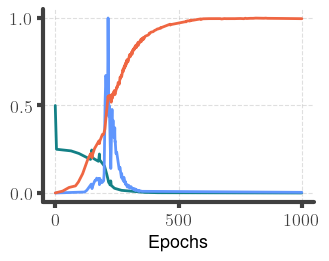

In [ ]:
## Plot trajectories

# Get data
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()

loss = compiler.trackers["loss"].get_trace().copy()
train_loss = loss.groupby("Epoch").mean()
train_loss = train_loss.to_numpy().ravel()

epochs = list(set(data_output.index.get_level_values("Epoch")))
epochs.sort()

N_pairs = 1

labels = set(data_hid.index.get_level_values("Input"))
labels.remove("initial")
labels = list(labels)
potential_labels_A = labels
potential_labels_B = labels

A_label_sim = random.sample(potential_labels_A, N_pairs)
B_label_sim = []
for a in A_label_sim:
    while True:
        b = np.random.choice(potential_labels_B)
        final_distance = np.linalg.norm(
            np.array(data_hid.loc[last_epoch, :, a])
            - np.array(data_hid.loc[last_epoch, :, b])
        )
        if (
            problem(list(map(int, a))) == problem(list(map(int, b)))
            and a != b
            and b not in B_label_sim
            and final_distance < threshold
        ):
            B_label_sim.append(b)
            break

h_A_sim = [
    np.array(data.loc[epoch, :, A_label_sim])
    for epoch, data in data_hid.groupby("Epoch")
]
h_B_sim = [
    np.array(data.loc[epoch, :, B_label_sim])
    for epoch, data in data_hid.groupby("Epoch")
]
H_sim = np.array(
    [np.sum((h_A_sim[epoch] - h_B_sim[epoch]) ** 2, axis=1) for epoch in epochs]
)

A_label_diff = random.sample(potential_labels_A, N_pairs)
B_label_diff = []
for a in A_label_diff:
    while True:
        b = np.random.choice(potential_labels_B)
        if (
            problem(list(map(int, a))) != problem(list(map(int, b)))
            and a != b
            and b not in B_label_diff
        ):
            B_label_diff.append(b)
            break

h_A_diff = [
    np.array(data.loc[epoch, :, A_label_diff])
    for epoch, data in data_hid.groupby("Epoch")
]
h_B_diff = [
    np.array(data.loc[epoch, :, B_label_diff])
    for epoch, data in data_hid.groupby("Epoch")
]
H_diff = np.array(
    [np.sum((h_A_diff[epoch] - h_B_diff[epoch]) ** 2, axis=1) for epoch in epochs]
)

t = np.linspace(0, len(epochs), len(epochs))

## Plot trajectories
figsize = (3.5, 2.5)
fig, ax = plt.subplots(figsize=figsize)
publication.set_color_mixed()
plt.gca().set_prop_cycle(None)
plt.plot(epochs, train_loss, label="Training loss")
for k, h in enumerate(np.transpose(H_sim)):
    publication.set_color_mixed()
    plt.gca().set_prop_cycle(None)
    publication.skip_colors(5)
    ax.plot(t, h / np.max(h), label=f"{A_label_sim[k]} {B_label_sim[k]}")
for k, h in enumerate(np.transpose(H_diff)):
    plt.gca().set_prop_cycle(None)
    publication.skip_colors(5)
    publication.skip_colors(1)
    ax.plot(t, h / np.max(h), label=f"{A_label_diff[k]} {B_label_diff[k]}")

# plt.xlim(300, 500)
plt.xlabel("Epochs")
publication.plt_show(save_path=f"plots/{settings}_trajectories")

100%|██████████| 1000/1000 [00:07<00:00, 132.84it/s]


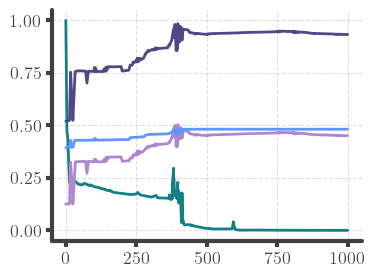

In [ ]:
# Plot trajectories

# Get data
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()

loss = compiler.trackers["loss"].get_trace().copy()
train_loss = loss.groupby("Epoch").mean()
train_loss = train_loss.to_numpy().ravel()

epochs = list(set(data_output.index.get_level_values("Epoch")))
epochs.sort()

N_pairs = 1000

labels = set(data_hid.index.get_level_values("Input"))
labels.remove("initial")
labels = list(labels)

A_label = np.random.choice(labels, size=N_pairs)
B_label = np.random.choice(labels, size=N_pairs)

H_sim, H_diff = [], []
for k in trange(0, N_pairs):
    a, b = A_label[k], B_label[k]
    h_A = np.array(data_hid.loc[:, :, a])
    h_B = np.array(data_hid.loc[:, :, b])
    H = np.linalg.norm(h_A - h_B, axis=1)
    if problem(list(map(int, a))) == problem(list(map(int, b))):
        H_sim.append(H)
    else:
        H_diff.append(H)


t = np.linspace(0, len(epochs), len(epochs))

indicators_same, indicators_diff = [], []
for k, h in enumerate(H_sim):
    indicator = h > threshold
    indicators_same.append(indicator)
for k, h in enumerate(H_diff):
    indicator = h > threshold
    indicators_diff.append(indicator)
sum_same = np.sum(np.array(indicators_same), axis=0)
sum_diff = np.sum(np.array(indicators_diff), axis=0)

plt.figure(figsize=(4, 3))
publication.set_color_mixed()
plt.plot(t, train_loss / np.max(train_loss), label="Training loss")
publication.skip_colors(1)
plt.plot(t, (sum_same + sum_diff) / N_pairs, label="Splits total")
publication.skip_colors(1)
plt.plot(t, sum_same / N_pairs, label="Splits same")
plt.plot(t, sum_diff / N_pairs, label="Splits diff")
publication.plt_show(save_path="plots/n_states")

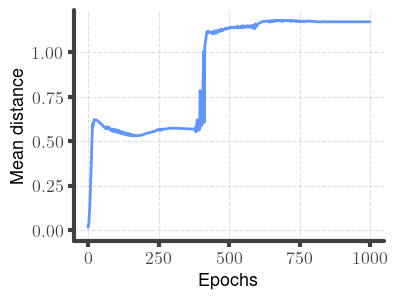

In [ ]:
## Average representational distance over time
plt.figure(figsize=(4, 3))
publication.set_color_mixed()
publication.skip_colors(5)
plt.plot(np.mean(np.concat((np.array(H_sim), np.array(H_diff))), axis=0))
plt.xlabel("Epochs")
plt.ylabel("Mean distance")
publication.plt_show(save_path="plots/mean_distance")

In [21]:
## Define system of ODEs
@njit
def der(t, z, eta_h_1, eta_h_2, eta_a, eta_b, N, y11, y12, y22):
    """Right hand side of the ode system."""
    h_1, h_2, bD, by_1, by_2, b2, D2, Dy_1, Dy_2 = z
    h_mean = (h_1 + h_2) / 2
    h2_mean = (h_1**2 + h_2**2) / 2
    Dy_mean = (Dy_1 + Dy_2) / 2
    by_mean = (by_1 + by_2) / 2
    hb_mean = (h_1 * by_1 + h_2 * by_2) / 2
    Dhy_mean = (h_1 * Dy_1 + h_2 * Dy_2) / 2
    hy2_mean_1 = (h_1 * y11 + h_2 * y12) / 2
    hy2_mean_2 = (h_1 * y12 + h_2 * y22) / 2
    return [
        -eta_h_1 * (1 / 2) * (bD + h_1 * D2 - Dy_1),
        -eta_h_2 * (1 / 2) * (bD + h_2 * D2 - Dy_2),
        -eta_b * (1 / N) * (bD + h_mean * D2 - Dy_mean)
        - eta_a * (1 / N) * (h2_mean * bD + h_mean * b2 - hb_mean),
        -eta_b * (1 / N) * (by_1 + h_mean * Dy_1 - (y11 + y12) / 2),
        -eta_b * (1 / N) * (by_2 + h_mean * Dy_2 - (y22 + y12) / 2),
        -eta_b * (2 / N) * (b2 + h_mean * bD - by_mean),
        -eta_a * (2 / N) * (h2_mean * D2 + h_mean * bD - Dhy_mean),
        -eta_a * (1 / N) * (h2_mean * Dy_1 + h_mean * by_1 - hy2_mean_1),
        -eta_a * (1 / N) * (h2_mean * Dy_2 + h_mean * by_2 - hy2_mean_2),
    ]


@njit
def get_train_loss(h_1, h_2, bD, by_1, by_2, b2, D2, Dy_1, Dy_2, y11, y22):
    return 0.5 * (
        b2
        + D2 * (h_1**2 + h_2**2) / 2
        + (y11 + y22) / 2
        + 2 * bD * (h_1 + h_2) / 2
        - 2 * (h_1 * Dy_1 + h_2 * Dy_2) / 2
        - 2 * (by_1 + by_2) / 2
    )

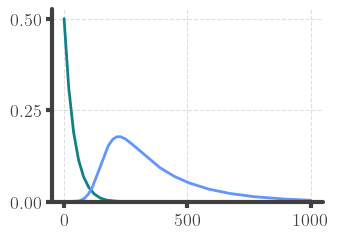

In [ ]:
## Plot trajectories

gain = data_hid.query("Epoch == 0 and Dataset == 0").std().std()

## Data variables
N = 1
len_1, len_2 = 1, 10
y_1, y_2 = 1, 1
y11, y12, y22 = y_1**2, y_1 * y_2, y_2**2

## Initial parameters
h_1_0, h_2_0, D2_0, b2_0 = (
    np.random.normal(0, gain),
    np.random.normal(0, gain),
    np.random.normal(0, gain) ** 2,
    np.random.normal(0, gain) ** 2,
)
theta_bD, theta_by_1, theta_by_2, theta_Dy_1, theta_Dy_2 = (
    2 * np.random.beta(2, 2, 5) - 1
)
theta_bD, theta_by_1, theta_by_2, theta_Dy_1, theta_Dy_2 = (0, 0, 0, 0, 0)
bD_0, by_1_0, by_2_0, Dy_1_0, Dy_2_0 = (
    theta_bD * np.sqrt(b2_0 * D2_0),
    theta_by_1 * np.sqrt(b2_0 * y_1**2),
    theta_by_2 * np.sqrt(b2_0 * y_2**2),
    theta_Dy_1 * np.sqrt(D2_0 * y_1**2),
    theta_Dy_2 * np.sqrt(D2_0 * y_2**2),
)

## Effective learning rates
eta_h_1, eta_h_2, eta_a, eta_b = (
    lr * len_1,
    lr * len_2,
    lr,
    0.25 * lr,
)

sol = scipy.integrate.solve_ivp(
    der,
    [0, n_epochs],
    [h_1_0, h_2_0, bD_0, by_1_0, by_2_0, b2_0, D2_0, Dy_1_0, Dy_2_0],
    args=(eta_h_1, eta_h_2, eta_a, eta_b, N, y11, y12, y22),
    dense_output=True,
)
t = np.linspace(0, n_epochs, n_epochs)
z = sol.sol(t)
h_1, h_2, bD, by_1, by_2, b2, D2, Dy_1, Dy_2 = z
train_loss = get_train_loss(h_1, h_2, bD, by_1, by_2, b2, D2, Dy_1, Dy_2, y11, y22)

publication.set_color_mixed()
fig, ax = plt.subplots(figsize=(3.5, 2.5))
plt.plot(t, train_loss, label="train loss")
publication.skip_colors(4)
plt.plot(t, (h_2 - h_1) ** 2, label="dh")
plt.ylim(0)
# plt.legend()
publication.plt_show(save_path="plots/theory_trajectories")

100%|██████████| 108/108 [00:35<00:00,  3.06it/s]


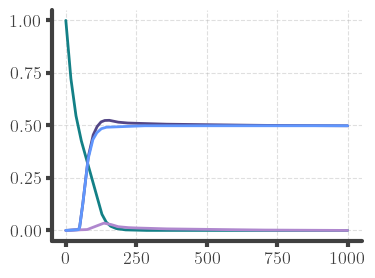

In [ ]:
## Plot number of states

thresh = threshold
gain = data_hid.query("Epoch == 0 and Dataset == 0").std().std()

fraction = 0.05
train_data = [
    x
    for n in range(1, max_seq_len + 1)
    for x in gen_rand_seq(n=n, symbols=[0, 1], n_sequences=fraction * 2**n)
]

indicators_same = []
indicators_diff = []
train_loss = np.zeros(n_epochs)
for x in tqdm(train_data):
    for y in train_data:
        i, j = len(x), len(y)

        ## Data variables
        N = 1
        y_1, y_2 = problem(x), problem(y)
        y11, y12, y22 = y_1**2, y_1 * y_2, y_2**2

        ## Initial parameters
        h_1_0, h_2_0, D2_0, b2_0 = (
            np.random.normal(0, gain),
            np.random.normal(0, gain),
            np.random.normal(0, gain) ** 2,
            np.random.normal(0, gain) ** 2,
        )
        theta_bD, theta_by_1, theta_by_2, theta_Dy_1, theta_Dy_2 = (
            2 * np.random.beta(2, 2, 5) - 1
        )
        theta_bD, theta_by_1, theta_by_2, theta_Dy_1, theta_Dy_2 = 0, 0, 0, 0, 0
        bD_0, by_1_0, by_2_0, Dy_1_0, Dy_2_0 = (
            theta_bD * np.sqrt(b2_0 * D2_0),
            theta_by_1 * np.sqrt(b2_0 * y_1**2),
            theta_by_2 * np.sqrt(b2_0 * y_2**2),
            theta_Dy_1 * np.sqrt(D2_0 * y_1**2),
            theta_Dy_2 * np.sqrt(D2_0 * y_2**2),
        )

        ## Effective learning rates
        eta_h_1, eta_h_2, eta_a, eta_b = (
            lr * i,
            lr * j,
            lr,
            0.25 * lr,
        )

        ## Simulate
        sol = scipy.integrate.solve_ivp(
            der,
            [0, n_epochs],
            [h_1_0, h_2_0, bD_0, by_1_0, by_2_0, b2_0, D2_0, Dy_1_0, Dy_2_0],
            args=(eta_h_1, eta_h_2, eta_a, eta_b, N, y11, y12, y22),
            dense_output=True,
        )
        t = np.linspace(0, n_epochs, n_epochs)
        z = sol.sol(t)
        h_1, h_2, bD, by_1, by_2, b2, D2, Dy_1, Dy_2 = z

        indicator = np.abs(h_2 - h_1) > thresh
        if y_1 == y_2:
            indicators_same.append(indicator)
        else:
            indicators_diff.append(indicator)

        train_loss += get_train_loss(
            h_1, h_2, bD, by_1, by_2, b2, D2, Dy_1, Dy_2, y11, y22
        )

sum_same = np.sum(np.array(indicators_same), axis=0)
sum_diff = np.sum(np.array(indicators_diff), axis=0)

n_pairs = len(train_data) ** 2

plt.figure(figsize=(4, 3))
publication.set_color_mixed()
plt.plot(t, train_loss / np.max(train_loss), label="Training loss")
publication.skip_colors(1)
plt.plot(t, (sum_same + sum_diff) / n_pairs, label="Splits total")
publication.skip_colors(1)
plt.plot(t, sum_same / n_pairs, label="Splits same")
plt.plot(t, sum_diff / n_pairs, label="Splits diff")

# plt.legend()
publication.plt_show(save_path="plots/theory_n_states")